# NYPD Civilian Complaints
## Classification ML Model
# Summary of Findings


### Introduction
The NYPD dataset contains information about 33,358 individual civillian complaints made against the NYPD's MOS (Member of Service) and their case results. This project intends to use the information from this dataset and use them as features in a classification model which will predict whether a case was substantiated or not. The outcome of the case was chosen as the target variable because it can help tell us if there are any particular features that are important in determining how a case is decided. This target variable was created by engineering the (`board_disposition`) variable and inputting True or False depending on whether or not the case was substantiated or not. To measure how well the model works, the evaluation metric used will be the F-1 Score. The F-1 Score is an appropriate metric to use for this project because it measures how well a model is at correctly classifying true positives. In this context, it means that the F-1 score will measure the model based on how well it will positively classify the cases that should be charged as "charged".  

### Baseline Model
For the baseline classification model, a DecisionTreeClassifier was used. There are 12 features being used: `month_received`, `year_received`, `month_closed`, `year_closed`, `rank_now`, `rank_incident`, `complainant_ethnicity`, `mos_ethnicity`, `fado_type`, `complainant_gender`, `complainant_age_incident`, `mos_age_incident`. There are two quantitative features: the complainant's age and member of service's age at the time of the incident. There are six ordinal features: the months and the years the complaint was received and closed (4) and the ranks of the MOS at the time of the incident and now (2). The remaining three columns, which are the ethnicities of the complainant and MOS, and the FADO type, are nominal. After calculating the F-1 score on the model, it resulted in a value around 0.4259. This is not a good score because it demonstrates that the model does not measure positive instances well, which in this context means. the model does not reliably categorize officers who should be charged as "charged".

We used these 12 features for the baseline and final models because the time of prediction will be once the board closes the case, but there is no board disposition announced yet. This means that we cannot use this model to predict ongoing cases, which can be a shortcoming. If we wanted to predict ongoing cases, we would need to disregard the features for the month and date the case was closed because that is unknown at the time of prediction. We would still be able to use the current rank of the officer, as well as the rest of the features because they would all be available.

### Final Model
For the final model, the four engineered features that were added are the length of the board's investigation, the ranking change of the accused MOS, the standardization of the MOS's age at the time of the incident based on the FADO type, and the standardization of the complainant's age at the time of the incident based on their ethnicity. The investigation time was included as a new variable because having a longer investigation time could potentially lead to a case being unsubstantiated as a prolonged investigation could be seen as pointless and thus dropped. The ranking change variable could provide information on the outcome because if a ranking change occured, it could possibly mean that they were demoted as a result of punishment for their involvement in a substantiated case. The standardization of MOS and complainant age based on FADO type and ethnicity, respectively, was included because standardizing the ages based on these groups could provide interesting insights on how a case would turn out (i.e. the FADO types that are more "aggressive" could show that the age of the MOS involved with those types are younger and is more associated with that specific FADO type or that younger people of a particular ethnicity would be more likely to make a complaint than others). For easier comparison, a DecisionTreeClassifier was used again with the default max_depth (None), min_samples_leaf of 3, and a min_samples_split of 3. The model was selected using the `best_estimator` method on the classifier, which was the estimator that gave the highest F-1 score. The model with the feature engineered variables did not fare better than the baseline model, as the final model had an F-1 score around 0.3584 due to the low precision. The baseline model had a better performance than the model with the engineered variables. We decided that in future iterations of this algorithm, it may be worth using a RandomForestClassifier because the lower variance would yield more generalized results.

### Fairness Evaluation
We will be evaluating the fairness of our algorithm using the True Positive Parity measure. We want to explore whether the model is more fair for non-black complainants than black complainants. More specifically, since we define fairness to be the TPR, or recall, we will see whether the algorithm correctly charges a higher proportion of guilty officers when the complainant is non-black than when the complainant is black. We have split the dataset into subsets: a black subset and a non-black subset. A permutation test will be used to determine if the algorithm is correctly charging the guilty officers. The hypotheses for the permutation test are below. 

* Null Hypothesis: The true positive rate for the complaints with black complainants and non-black complainants is roughly the same, indicating that the model is fair.
* Alternative Hypothesis: The model poses unjust circumstances for black people by having a lower true positive rate for charging guilty officers than when the complainant is non-black.

After the permutation test was run, the p-value calculated was 0.483. This indicates that under the null hypothesis, around 50% of the observed differences in TPR were at least as extreme as the observed difference. Since the p-value is higher than the significance level of 0.05, we fail to reject the null hypothesis and do not have evidence to conclude that the algorithm poses unjust circumstances to black complainants.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# Import transformers
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Import for creating transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Import pipeline
from sklearn.pipeline import Pipeline

# Import classifier and parameter selection 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Import model selection and metrics
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
complaints = pd.read_csv('data/allegations_202007271729.csv')
complaints.head(3)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)


From the NYPD civilian complaints dataset, we are attempting to predict the result of a civilian claim. We aim to predict whether or not the Allegation resulted in a charge on the police officer after the Board investigation. This problem is a binary classification problem, where the target variable is an engineered Board Disposition (`board_disposition`) variable. In order to make this a binary problem, we will be grouping "Exonerated" and "Unsubstantiated" results into the "Officer Not Charged", or class with value 0. All the "Substantiated" claims will be classified as "Officer Charged", or class with value 1.

We will be using the F1-score as the evaluation metric. This is due to the fact that accuracy treats the incorrect guesses equally. Treating False Positives (predicting the officer is charged when the officer should not be charged) and False Negatives (predicting the officer is not charged when the officer should be charged) can have detrimental impacts. We want to weigh more importance to the False Negatives because having a person in abuse of their power still work their job puts more civilians at risk. The F1-score, which is the harmonic mean of precision and recall. Precision, in this context, measures how many officers we correctly predicted as charged as a fraction of the total number of officers we predicted as charged. Recall, in this context, measures how many officers we correctly predicted as charged as a fraction of the total number of officers who should have been charged. We want to maximize both precision and recall, so F1-score is the most useful evaluation metric.

#### Preliminary Data Cleaning

In [3]:
# Creates a new column for the full name of the MOS because the individual first and last names are not meaningful for our analysis.
complaints = complaints.assign(mos_name = (complaints['first_name'] + ' ' + complaints['last_name'])).drop(columns = ['first_name', 'last_name'])

### Baseline Model

In the baseline model, we will be predicting the Board Disposition using 12 features: `month_received`, `year_received`, `month_closed`, `year_closed`, `rank_now`, `rank_incident`, `complainant_ethnicity`, `mos_ethnicity`, `fado_type`, `complainant_gender`, `complainant_age_incident`, `mos_age_incident`. 
There are two quantitative features: the complainant's age and member of service's age at the time of the incident. There are six ordinal features: the months and the years the complaint was received and closed (4) and the ranks of the MOS at the time of the incident and now (2). The remaining three columns, which are the ethnicities of the complainant and MOS, and the FADO type, are nominal.

In [4]:
# Feature engineering the output column to a boolean array to allow binary classification 
complaints['is_charged'] = complaints['board_disposition'].str.contains('Substantiated')
complaints.head(3)

,unique_mos_id,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,...,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,mos_name,is_charged
0,10004,078 PCT,8409,42835,7,2019,5,2020,078 PCT,POM,...,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions),Jonathan Ruiz,True
1,10007,078 PCT,5952,24601,11,2011,8,2012,PBBS,POM,...,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),John Sears,True
2,10007,078 PCT,5952,24601,11,2011,8,2012,PBBS,POM,...,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),John Sears,True


In [5]:
def _turn_ages_nan(df):
    # Input will be a DataFrame from the pipeline. Converts the dataframe to an array and flattens to 1D
    # Turns ages to NaN if there are less than or equal to 10
    with_nans_series = pd.Series(np.array(df).flatten()).apply(lambda y: np.NaN if y <= 10 else y)
    
    # Casts the series to an array of type float
    with_nans_arr = np.array(with_nans_series).astype(float)
    
    # Reshapes the array to a 2D array because pipeline output must be 2D array
    return np.reshape(with_nans_arr, (df.shape[0], 1))

# Pipeline to clean the ages (turning dubious ages into NaN) and subsequently filling NaNs with the median
age_impute_pipe = Pipeline([
    ('func', FunctionTransformer(_turn_ages_nan)),
    ('imp', SimpleImputer(strategy = 'median'))
])

In [6]:
def _make_genders_unknown(df):
    # Input will be a DataFrame from the pipeline. Converts the dataframe to an array and flattens to 1D
    # Makes one column called Unknown, which is what NaNs will become
    with_unknown_ser = pd.Series(np.array(df).flatten()).str.replace('Not described', repl = 'Unknown')
    
    # Casts the series to an array of type float
    with_unknown_arr = np.array(with_unknown_ser)
    
    # Reshapes the array to a 2D array because pipeline output must be 2D array
    return np.reshape(with_unknown_arr, (df.shape[0], 1))

# Pipeline to clean the genders (turning NaNs into Unknown and turning 'Not Described' into 'Unknown')
# Subsequently one-hot encoding the genders
gender_impute_pipe = Pipeline([
    ('imp', SimpleImputer(strategy = 'constant', fill_value = 'Unknown')),
    ('func', FunctionTransformer(_make_genders_unknown)),
    ('oh', OneHotEncoder(handle_unknown = 'ignore'))
])

In [7]:
# Pipeline to fill NaN ethnicities with the 'Unknown' tag and subsequently one-hot encode
eth_impute_pipe = Pipeline([
    ('imp', SimpleImputer(strategy = 'constant', fill_value = 'Unknown')),
    ('oh', OneHotEncoder(handle_unknown = 'ignore'))
])

In [8]:
# One-hot encoding pipeline for the rest of the categorical variables
one_hot_pipe = Pipeline([
    ('oh', OneHotEncoder(handle_unknown = 'ignore'))
])

In [9]:
# ColumnTransformer to transform genders, ethnicities, ages, one-hot encode the rest of the categorical variables, and pass through the other features
column_trans_pipeline = ColumnTransformer(transformers= [
    ('gen', gender_impute_pipe, ['complainant_gender']),
    ('eth', eth_impute_pipe, ['complainant_ethnicity']),
    ('age', age_impute_pipe, ['complainant_age_incident']),
    ('oh', one_hot_pipe, ['rank_now', 'rank_incident', 'mos_ethnicity', 'fado_type'])], remainder = 'passthrough')

In [10]:
# Full pipeline with the transforms for the columns and the classifier
pipe = Pipeline(
    steps=[('feature_eng', column_trans_pipeline),
           ('classifier', DecisionTreeClassifier())])

In [11]:
# List of features to be used in the algorithm
feature_cols = ['month_received', 'year_received', 'month_closed', 'year_closed', \
'rank_now', 'rank_incident', 'complainant_ethnicity', \
'mos_ethnicity', 'fado_type', 'complainant_gender', \
'complainant_age_incident', 'mos_age_incident']

X = complaints[feature_cols]  # DataFrame
y = complaints['is_charged'] # Series

# Create 70/30 split for training sets (_tr) and test sets (_ts)
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y, test_size=0.30)

In [12]:
# Fit the full pipeline to the training sets
pipe.fit(X_tr, y_tr)

Pipeline(steps=[('feature_eng',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('gen',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('func',
                                                                   FunctionTransformer(func=<function _make_genders_unknown at 0x7f88c6d9e050>)),
                                                                  ('oh',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['complainant_gender']),
                                                 ('eth',
                                  

In [13]:
# Form predictions on the test set and stores it in preds
preds = pipe.predict(X_ts)
preds

array([False,  True, False, ..., False, False, False])

In [14]:
# Calculate recall (TPR): ratio of correctly identified positives over the total actual positives
metrics.recall_score(y_ts, preds) 

0.4197480698902885

In [15]:
# Calculate precision (PPV): ratio of correctly identified positives over the total predicted positives
metrics.precision_score(y_ts, preds)

0.4322175732217573

In [16]:
# Calculates F1 score: harmonic mean of recall and precision
metrics.f1_score(y_ts, preds)

0.42589156874871165

The baseline performance, measured by the F1-score, was around 0.4259. This is not a good score because it demonstrates that the model does not measure positive instances well. In this context, this means that the model does not reliably categorize officers who should be charged as "charged". This has major implications, as previously mentioned, because it can lead to complacency and a lack of accountability as there will be officers who abused their power still in the workforce.

### Final Model

In the improved model, we engineered 4 new features: the length of the board's investigation, the ranking change of the accused MOS, the standardization of the MOS's age at the time of the incident based on the FADO type, and the standardization of the complainant's age at the time of the incident based on their ethnicity. For the sake of control, the 12 feature columns will remain the same in the final model and baseline model, but we will be feature engineering variables with the goal of reducing multicollinearity and possibly increase the performance of the model by identifying previously unseen trends in the data.

In [17]:
# Adds the StdScalerByGroup transformer class from Lab 9
class StdScalerByGroup(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 2, 2], 'c2': [3, 1, 2, 0]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> std.grps_ is not None
        True
        """
        # X may not be a pandas dataframe (e.g. a np.array)
        df = pd.DataFrame(X)

        # Finds the name of the group column and numerical column
        group_col = df.columns[0]
        numerical_col = df.columns[1]
        
        # Casts the numerical column values to a float explicitly because DataFrame turns it into object type
        df[numerical_col] = df[numerical_col].astype(float)

        # Calculates the mean and std by group
        means = df.groupby(group_col).mean()
        stds = df.groupby(group_col).std()

        # Creates DataFrame with means and stds for each column, for each group
        aggregates = pd.merge(left = means, right = stds, left_index = True, right_index = True, suffixes = ['_mean', '_std'])

        # A dictionary of means/standard-deviations for each column, for each group.
        self.grps_ = aggregates

        return self

    def transform(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 3, 4], 'c2': [1, 2, 3, 4]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> out = std.transform(X)
        >>> out.shape == (4, 2)
        True
        >>> np.isclose(out.abs(), 0.707107, atol=0.001).all().all()
        True
        """
        # Catches unfit transformers and gets the groups if fitted
        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("You must fit the transformer before tranforming the data!")

        # Helper function to standardize a specific column
        def _standardize_col(col_name):
            # For the input column, makes two names for columns
            mean_col = str(col_name) + '_mean'
            std_col = str(col_name) + '_std'

            # Standardizes the groups based on the categorical column
            standardized = df.groupby(group_col)[col_name].transform(lambda x: (x - self.grps_.loc[x.name, mean_col])/self.grps_.loc[x.name, std_col])
            return standardized

        # X may not be a dataframe (e.g. np.array)
        df = pd.DataFrame(X)
        output_df = pd.DataFrame()

        # Finds the name of the group column
        group_col = df.columns[0]

        # Standardizes all of the numerical columns and makes an output DataFrame with the standardized columns by group
        numerical_cols = list(df.columns[1:])

        for col in numerical_cols:
            output_df[str(col) + '_z'] = _standardize_col(col)
        
        return output_df

In [18]:
# Only imputes the NaN ethnicities with 'Unknown'. Does NOT one-hot encode because this will be used in StdScalerByGroup
eth_impute_only = Pipeline([
    ('imp', SimpleImputer(strategy = 'constant', fill_value = 'Unknown'))
])

In [19]:
# Cleans the ethnicities and ages. Age pipeline is the same from baseline model
cleaning_pipe = ColumnTransformer([
    ('eth', eth_impute_only, ['complainant_ethnicity']),
    ('age', age_impute_pipe, ['complainant_age_incident']),
])

In [20]:
# Pipeline for cleaning the ethnicity and ages, and then scales the ages by ethnicity of the complainant
scale_cleaned = Pipeline([
    ('clean', cleaning_pipe),
    ('std', StdScalerByGroup())
])

In [21]:
# Function for getting the time that an investigation was conducted for
def _get_investigation_time(arr):
    # Extracts the columns from the input array. Input will be array because validate = True for dates transformer
    month_received = arr[:,0].astype(str)
    year_received = arr[:,1].astype(str)
    month_closed = arr[:,2].astype(str)
    year_closed = arr[:,3].astype(str)
    
    # Series of dashes which will be used to concatenate the months and years
    dashes = np.repeat('-', len(month_received))
    
    # Forms the dates from the months and years
    date_received = pd.to_datetime(list(map(''.join,zip(month_received, dashes, year_received))))
    date_closed = pd.to_datetime(list(map(''.join,zip(month_closed, dashes, year_closed))))
    
    # Finds durations and casts the TimeDelta to float
    durations = np.array(date_closed - date_received).astype(float)
    
    # Reshapes the durations array to a 2D array
    return np.reshape(durations, (durations.shape[0], 1))

In [22]:
# Function for checking whether the rank of the officer changed from the incident to now
def _check_rank(df):
    # Extracts the rank columns. Order does not matter because we will check for equality
    rank1 = df.iloc[:,0]
    rank2 = df.iloc[:,1]
    
    # Checks whether the rank remained constant
    equality = np.array(rank1 == rank2)
    
    # Reshapes the durations array to a 2D array
    return np.reshape(equality, (equality.shape[0], 1))

In [23]:
# Pipeline with all the feature engineering. Feature columns are the same as baseline but there are 4 engineered features
feature_eng_pipeline = ColumnTransformer([
    ('dates', FunctionTransformer(_get_investigation_time, validate = True), ['month_received', 'year_received', 'month_closed', 'year_closed']),
    ('std_comp', scale_cleaned, ['complainant_ethnicity', 'complainant_age_incident']),
    ('gen', gender_impute_pipe, ['complainant_gender']),
    ('rank', FunctionTransformer(_check_rank), ['rank_now', 'rank_incident']),
    ('oh', OneHotEncoder(handle_unknown = 'ignore'), ['mos_ethnicity']),
    ('std_mos', StdScalerByGroup(), ['fado_type', 'mos_age_incident'])
])

As previously mentioned, the feature columns and classifier will not be changed from the baseline model because we want to control as many variables as possible. The only difference will be the engineered columns and the optimized parameters we select for the classifier by conducting a GridSearch Cross Validation.

In [24]:
# Full pipeline with the transforms for the columns and the classifier
pipe = Pipeline(
    steps=[('feature_eng', feature_eng_pipeline),
           ('classifier', DecisionTreeClassifier())])

In [25]:
X = complaints[feature_cols]  # DataFrame
y = complaints['is_charged'] # Series

# Create 70/30 split for training sets (_tr) and test sets (_ts)
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y, test_size=0.30)

We will first fit the classifier on the default classifier and then conduct a GridSearchCV to find the optimal parameters.

In [26]:
# Fit the pipeline on the training sets
pipe.fit(X_tr, y_tr);

In [27]:
# Form predictions on the test set
preds = pipe.predict(X_ts)
preds

array([False, False, False, ...,  True, False,  True])

In [28]:
# Calculate recall (TPR): ratio of correctly identified positives over the total actual positives
metrics.recall_score(y_ts, preds) 

0.39588377723970947

In [29]:
# Calculate precision (PPV): ratio of correctly identified positives over the total predicted positives
metrics.precision_score(y_ts, preds)

0.43971313312415955

In [30]:
# Calculates F1 score: harmonic mean of recall and precision
metrics.f1_score(y_ts, preds)

0.41664897005733703

We will now use GridSearchCV to find the optimal parameters for the DecisionTreeClassifier. Once we find the optimal classifier, we will use that to predict whether a MOS was charged or not.

In [31]:
# Choice of parameters in the classifier to be optimized in GridSearchCV
parameters = {
    'classifier__max_depth': [2,3,4,5,7,10,13, None], 
    'classifier__min_samples_split':[2,3,5,7,10],
    'classifier__min_samples_leaf':[2,3,5,7,10]
}

In [32]:
# Initializes GridSearchCV object for the pipeline, specified parameters, 5 folds, and F1 metric
clf = GridSearchCV(pipe, param_grid = parameters, cv = 5, scoring = 'f1')

In [33]:
# Fit the classifier on the training sets
clf.fit(X_tr, y_tr);

In [34]:
clf.best_params_

{'classifier__max_depth': None,
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 3}

In [35]:
# Calculate recall (TPR): ratio of correctly identified positives over the total actual positives
metrics.recall_score(clf.best_estimator_.predict(X_ts), y_ts)

0.41012909632572

In [36]:
# Calculate precision (PPV): ratio of correctly identified positives over the total predicted positives
metrics.precision_score(clf.best_estimator_.predict(X_ts), y_ts)#.sum()

0.3333333333333333

In [37]:
# Calculates F1 score: harmonic mean of recall and precision
clf.score(X_ts, y_ts)

0.3677649154051647

In [38]:
# Calculates the average F1 score of the CV folds for the best combination of paramets
clf.best_score_

0.35838859667981054

The average F1-score of the cross-validation folds was significantly worse in the model with engineered features than compared to the baseline model. The reason the F1-score was so low, around 0.3584, was due to the precision. This means out of all of the MOS that the algorithm classified as 'charged', only around 33.3% were correctly identified. This can have bad consequences because this algorithm may classify officers as guilty if they may not be guilty.

The DecisionTreeClassifier fell short because it does not generalize well. The higher performance in the baseline model may have been due to overfitting the data, but the variance was too high, indicating a weaker performance on previously unseen data. A RandomForestClassifier may have been a stronger choice for an algorithm for its generalization.

### Fairness Evaluation

We will be evaluating the fairness of our algorithm using the True Positive Parity measure. We want to explore whether the model is more fair for non-black complainants than black complainants. More specifically, since we define fairness to be the TPR, or recall, we will see whether the algorithm correctly charges a higher proportion of guilty officers when the complainant is non-black than when the complainant is black. We have split the dataset into subsets: a black subset and a non-black subset.

* Null Hypothesis: The true positive rate for the complaints with black complainants and non-black complainants is roughly the same, indicating that the model is fair.
* Alternative Hypothesis: The model poses unjust circumstances for black people by having a lower true positive rate for charging guilty officers than when the complainant is non-black.

We will be conducting the permutation test at a significance level of 0.05.

In [39]:
# Sets the results dataframe to the test set observations
results = X_ts

In [40]:
# Uses the optimal classifier from the GridSearchCV to make predictions from the test set 
preds = clf.predict(X_ts)
preds

array([False, False, False, ...,  True, False, False])

In [41]:
# Groups the observed complainants in the results dataset into black or non-black
is_black = (results['complainant_ethnicity'] == 'Black')

In [42]:
# Creates three new columns in the results DataFrame: boolean column for the group, predictions, and true tags
results = results.assign(is_black = is_black, prediction = preds, tag = y_ts)

In [43]:
results.head()

,month_received,year_received,month_closed,year_closed,rank_now,rank_incident,complainant_ethnicity,mos_ethnicity,fado_type,complainant_gender,complainant_age_incident,mos_age_incident,is_black,prediction,tag
3411,4,2009,1,2011,Police Officer,Police Officer,Unknown,White,Force,Male,41.0,33,False,False,False
2606,10,2003,5,2005,Detective,Police Officer,Black,Black,Force,Male,21.0,31,True,False,False
6831,8,2006,11,2007,Lieutenant,Lieutenant,Black,White,Discourtesy,Female,42.0,40,True,False,False
10693,8,2015,2,2016,Lieutenant,Lieutenant,NaN,White,Abuse of Authority,NaN,NaN,52,False,True,False
25838,12,2011,8,2012,Detective,Police Officer,Asian,White,Discourtesy,Male,26.0,28,False,False,False


In [44]:
# Calculates the observed recall (TPR) for the black and non-black groups from the algorithm
obs = results.groupby('is_black').apply(lambda x: metrics.recall_score(preds, y_ts)).diff().iloc[-1]

# List for holding the difference of TPR for the 1000 trials
metrs = []

# Permutation test for true positive parity
for _ in range(1000):
    # Permutes the is_black labels and finds the empirical difference of TPR for the black and non-black groups
    s = (
        results[['is_black', 'prediction', 'tag']]
        .assign(is_black = results.is_black.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_black')
        .apply(lambda x: metrics.recall_score(x.tag, x.prediction))
        .diff()
        .iloc[-1]
    )
    
    # Adds the empirical difference to the list storing all the differences
    metrs.append(s)

0.506


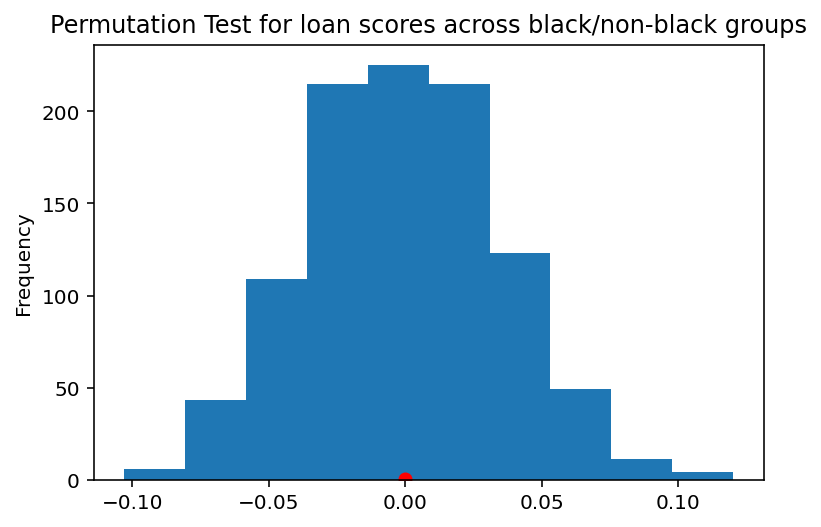

In [45]:
# p-value is the proportion of observed differences between TPR of black and non-black (in that order)
# that were equal or more extreme (less) than the observed difference
p_val = (pd.Series(metrs <= obs).mean())
print(p_val)

# Plots the observed difference as a red dot and the empirical differences as a histogram
pd.Series(metrs).plot(kind='hist', title='Permutation Test for loan scores across black/non-black groups')
plt.scatter(obs, 0.25, c='r', zorder = 2);

The p-value of 0.506 indicates that under the null hypothesis, around 50% of the observed differences in TPR were at least as extreme as the observed difference. Since the p-value is higher than the significance level of 0.05, we fail to reject the null hypothesis and do not have evidence to conclude that the algorithm poses unjust circumstances to black complainants.